In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F


class new_NN(nn.Module):
    '''
    5 hidden layer, 1 input, 1 output Neural network
    '''
    def __init__(self, hidden_size=20, learning_rate=0.001, patience=100, factor=0.5, threshold=1e-4):
        '''
        args:
            float learning_rate: how much should NN correct when it guesses wrong
            int patience: how many repeated values (plateaus or flat data) should occur before changing learning rate
            float factor: by what factor should learning rate decrease upon scheduler step
            float threshold: how many place values to consider repeated numbers
            
        '''
        super(new_NN, self).__init__()
        self.w = nn.Parameter(torch.rand(1))
        self.b = nn.Parameter(torch.rand(1))
        self.hidden1 = nn.Linear(1, hidden_size)
        self.hidden2 = nn.Linear(hidden_size, hidden_size)
        self.hidden3 = nn.Linear(hidden_size, hidden_size)
        self.hidden4 = nn.Linear(hidden_size, hidden_size)
        self.hidden5 = nn.Linear(hidden_size, hidden_size)
        self.output = nn.Linear(hidden_size, 1)
        self.relu = nn.ReLU()
        
        self.loss_data = {
            'loss':[],
            'epoch_count':[]
            }

        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        self.scheduler = ReduceLROnPlateau(self.optimizer, 'min', 
                                           factor=factor, patience=patience, threshold=threshold)

        
        
    def forward(self, x):
        '''
        args:
            x: single value or tensor to pass 
        returns:
            output of NN
        '''
        x = x * self.w + self.b
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        x = F.relu(self.hidden3(x))
        x = F.relu(self.hidden4(x))
        x = F.relu(self.hidden5(x))
        x = self.output(x)

        return x

    
    
    
    def train_model(self, x_train, y_train, num_epochs=1500):
        '''
        args:
            tensor x_train: input dataset to train NN
            tensor y_train: output dataset to train NN
            int num_epochs: iterations of training
        returns:
            dict loss_data: Dictionary with loss data to track training progress
        '''
        x_train = x_train.to(torch.float32)
        y_train = y_train.to(torch.float32)
        
        self.train()
        for epoch in range(num_epochs):
            self.optimizer.zero_grad()

            outputs = self(x_train)
            loss = self.criterion(outputs, y_train)
            loss.backward()
            self.optimizer.step()

            current_loss = loss.item()
            self.loss_data['loss'].append(current_loss)
            self.loss_data['epoch_count'].append(epoch)
            self.scheduler.step(current_loss)
            print(self.w)
            if (epoch + 1) % (num_epochs/10) == 0:
                #print(f'sim NN: Epoch [{epoch+1}/{num_epochs}], Loss:{loss.item():.6f}')
                print(self.w)


    
    
    
    def test_model(self, x_test, y_test):
        '''
        args:
            tensor x_test: an input dataset to pass through NN and test
            tensor y_test: an output dataset to pass through NN
        returns:
            numpy array output: Returns the predictions the NN made with x_test
        '''
        x_test = x_test.to(torch.float32)
        y_test = y_test.to(torch.float32)
        
        self.eval()
        with torch.no_grad():
            output = self(x_test)
            loss = self.criterion(output, y_test).item()
            print(f'Test Loss: {loss:.4f}')

    

    def predict(self, x_value):
        '''
        args:
            x_value: can be single value or array, to get run through NN
        returs:
            numpy array output: outputs from NN for each x point supplied
        '''
        self.eval()
        with torch.no_grad():
            output = self(x_value)
        return output.detach().numpy()





In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

import transformer
from NNsetup import NN 
from NNsetup import Combined_NN

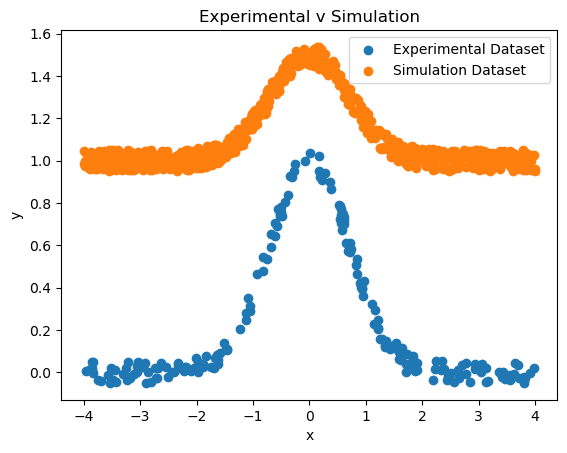

In [4]:
bound = 4

#function to produde results based on x values
def create_gaussian_curve(x, a, shift_up, shift_amp):
    #C + Aexp((-x-a)^2)
    y = shift_up + shift_amp*np.exp(-(x-a)**2) + np.random.uniform(-0.05, 0.05, size=x.shape)
    return y

# Generate 100 random points
np.random.seed(0)  # For reproducibility
N_exp_points = 50  # number of points from expt
N_sim_points = 200 # number of points from sims
exp_x_points = np.random.uniform(-bound, bound, bound*N_exp_points)
sim_x_points = np.random.uniform(-bound, bound, bound*N_sim_points)

#Compute results
sim_gaussian_center = 0
exp_gaussiam_center = 0
exp_y_points = create_gaussian_curve(exp_x_points,0, 0, 1)
sim_y_points = create_gaussian_curve(sim_x_points,0, 1, 0.5)

fig, ax = plt.subplots()


ax.scatter(exp_x_points, exp_y_points, label='Experimental Dataset')
ax.scatter(sim_x_points, sim_y_points, label='Simulation Dataset')

plt.title("Experimental v Simulation")
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

In [5]:
#function to split on a pivot oppsed to a percentage
def split_on_point(x_values, y_values, pivot):
    #initialize arrays
    x_train = []
    y_train = []
    x_test = []
    y_test = []
    
    #for each x, if it is above the pivot, add the x and it's correlating y value
    for i, x in enumerate(x_values):
        if x > pivot:
            x_train.append(x)
            y_train.append(y_values[i])
        else:
            x_test.append(x)
            y_test.append(y_values[i])
            
    #convert all training gand testing arrays to tensors
    x_train = torch.tensor(x_train, dtype=torch.float32).reshape(-1,1)
    y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1,1)
    x_test = torch.tensor(x_test, dtype=torch.float32).reshape(-1,1)
    y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1,1)
    return x_train, y_train, x_test, y_test

In [6]:
#Setting Bounds
x_bounds = torch.tensor([-bound, bound])
y_bounds = torch.tensor([0, 2])


#define transformers
x_transformer = transformer.Transformer(x_bounds.reshape(2,1), transform_type = 'normalize')
y_transformer = transformer.Transformer(y_bounds.reshape(2,1), transform_type = 'normalize')

#Full normalization process
def normalization(array, transformer):
    array = np.array(array).reshape(-1,1)
    array = torch.tensor(array)
    norm = transformer.forward(array)
    norm = torch.tensor(norm, dtype=torch.float32).reshape(-1,1)
    return norm

In [7]:
#normalize
sim_x_points = normalization(sim_x_points, x_transformer)
sim_y_points = normalization(sim_y_points, y_transformer)
exp_x_points = normalization(exp_x_points, x_transformer) 
exp_y_points = normalization(exp_y_points, y_transformer)

/var/folders/yy/n3t7phv166784l2_qxkc06vr0000gp/T/ipykernel_907/1192910090.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  norm = torch.tensor(norm, dtype=torch.float32).reshape(-1,1)


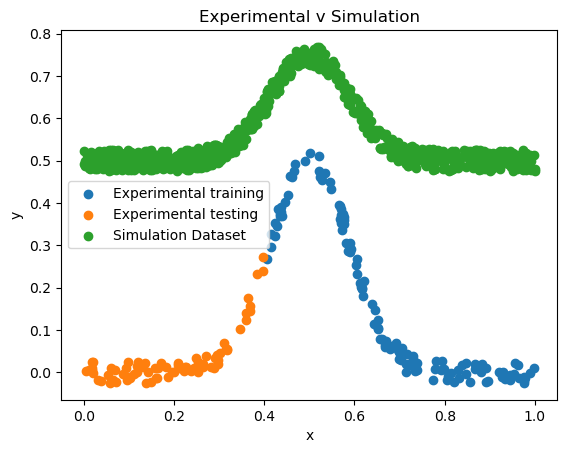

In [8]:
exp_x_train, exp_y_train, exp_x_test, exp_y_test = split_on_point(exp_x_points, exp_y_points, 0.4)

fig, ax = plt.subplots()

ax.scatter(exp_x_train, exp_y_train, label='Experimental training')
ax.scatter(exp_x_test, exp_y_test, label='Experimental testing')
ax.scatter(sim_x_points, sim_y_points, label='Simulation Dataset')

plt.title("Experimental v Simulation")
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

sim NN: Epoch [150/1500], Loss:0.006672
sim NN: Epoch [300/1500], Loss:0.003783
sim NN: Epoch [450/1500], Loss:0.001503
sim NN: Epoch [600/1500], Loss:0.000376
sim NN: Epoch [750/1500], Loss:0.000221
sim NN: Epoch [900/1500], Loss:0.000218
sim NN: Epoch [1050/1500], Loss:0.000217
sim NN: Epoch [1200/1500], Loss:0.000217
sim NN: Epoch [1350/1500], Loss:0.000217
sim NN: Epoch [1500/1500], Loss:0.000218


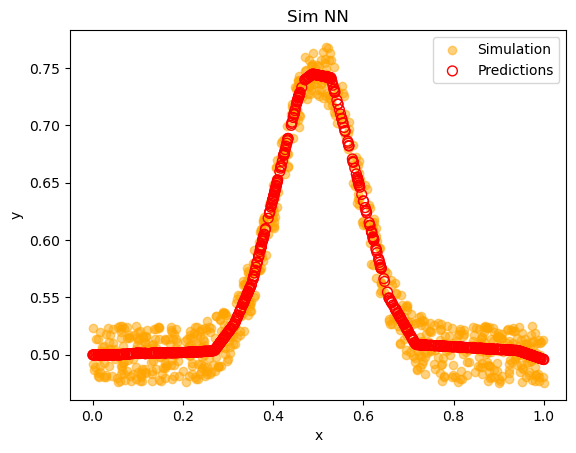

In [9]:
sim_net = NN()
sim_net.train_model(sim_x_points, sim_y_points)
sim_predictions = sim_net.predict(sim_x_points)


plt.scatter(sim_x_points, sim_y_points, label='Simulation', color='orange', alpha=0.5)
plt.scatter(sim_x_points, sim_predictions, label='Predictions', s=50, facecolors='none', edgecolors='r')
plt.title('Sim NN')  
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [10]:

class finetune_NN(NN):
    def __init__(self, base_model, hidden_size=20, 
                 learning_rate=0.0001, patience=100, factor=0.5, threshold=1e-4):
        super(finetune_NN, self).__init__(hidden_size, learning_rate, patience, factor, threshold)
        
        # Copying weights from base_model to this model
        self.w = torch.nn.Parameter(torch.rand(1))
        self.b = torch.nn.Parameter(torch.rand(1))
        #self.hidden0 = nn.Linear(1, 1)
        self.hidden1.load_state_dict(base_model.hidden1.state_dict())
        self.hidden2.load_state_dict(base_model.hidden2.state_dict())
        self.hidden3.load_state_dict(base_model.hidden3.state_dict())
        self.hidden4.load_state_dict(base_model.hidden4.state_dict())
        self.hidden5.load_state_dict(base_model.hidden5.state_dict())        
        self.output.load_state_dict(base_model.output.state_dict())
        self.w2 =torch.nn.Parameter(torch.rand(1))
        self.b2 = torch.nn.Parameter(torch.rand(1))
        self.relu = nn.ReLU()
        #self.linear = nn.Linear(1,20)
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        self.scheduler = ReduceLROnPlateau(self.optimizer, 'min', 
                                           factor=factor, patience=patience, threshold=threshold)
        
    def forward(self, x):
        x = x*self.w + self.b
        #x = self.linear(self.hidden0(x))
        x = self.relu(self.hidden1(x))
        x = self.relu(self.hidden2(x))
        x = self.relu(self.hidden3(x))
        x = self.relu(self.hidden4(x))
        x = self.relu(self.hidden5(x))
        x = self.output(x)
        x = x * self.w2 + self.b2
        # linear transform of output
        
        return x
    
    def train_model(self, x_train, y_train, num_epochs=1500):
        print(self.parameters())
        for param in self.hidden1.parameters():
            param.requires_grad = False
        for param in self.hidden2.parameters():
            param.requires_grad = False
        for param in self.hidden3.parameters():
            param.requires_grad = False
        for param in self.hidden4.parameters():
            param.requires_grad = False
        for param in self.hidden5.parameters():
            param.requires_grad = False
        for param in self.output.parameters():
            param.requires_grad = False
            
  
        x_train = x_train.to(torch.float32)
        y_train = y_train.to(torch.float32)
        
        self.train()
        for epoch in range(num_epochs):
            self.optimizer.zero_grad()

            outputs = self(x_train)
            loss = self.criterion(outputs, y_train)
            loss.backward()
            self.optimizer.step()

            current_loss = loss.item()
            self.loss_data['loss'].append(current_loss)
            self.loss_data['epoch_count'].append(epoch)
            self.scheduler.step(current_loss)

            if (epoch + 1) % (num_epochs/1000) == 0:
                print(f'Comb NN: Epoch [{epoch+1}/{num_epochs}], Loss:{loss.item():.6f}')
                print(self.w, self.b)
                print(self.w2,self.b2)



In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F


finetune_net = finetune_NN(sim_net)
finetune_net.train_model(exp_x_train,exp_y_train,num_epochs=100000)
finetune_net_pred = finetune_net.predict(exp_x_test)

<generator object Module.parameters at 0x15fb3a340>
Comb NN: Epoch [100/100000], Loss:0.278336
Parameter containing:
tensor([0.5806], requires_grad=True) Parameter containing:
tensor([0.2908], requires_grad=True)
Parameter containing:
tensor([0.7963], requires_grad=True) Parameter containing:
tensor([0.2243], requires_grad=True)
Comb NN: Epoch [200/100000], Loss:0.256780
Parameter containing:
tensor([0.5895], requires_grad=True) Parameter containing:
tensor([0.2999], requires_grad=True)
Parameter containing:
tensor([0.7867], requires_grad=True) Parameter containing:
tensor([0.2146], requires_grad=True)
Comb NN: Epoch [300/100000], Loss:0.238549
Parameter containing:
tensor([0.5969], requires_grad=True) Parameter containing:
tensor([0.3077], requires_grad=True)
Parameter containing:
tensor([0.7774], requires_grad=True) Parameter containing:
tensor([0.2051], requires_grad=True)
Comb NN: Epoch [400/100000], Loss:0.222484
Parameter containing:
tensor([0.6034], requires_grad=True) Parameter

In [12]:
for name, param in finetune_net.named_parameters():
    if param.requires_grad:
        print(name, param.data)

w tensor([1.0174])
b tensor([-0.0108])
w2 tensor([2.0402])
b2 tensor([-1.0264])


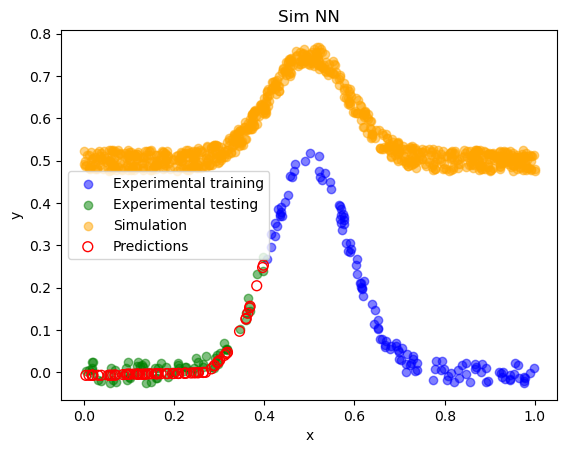

In [13]:
plt.scatter(exp_x_train, exp_y_train, label='Experimental training', color='blue', alpha=0.5)
plt.scatter(exp_x_test, exp_y_test, label='Experimental testing', color='green', alpha=0.5)
plt.scatter(sim_x_points, sim_y_points, label='Simulation', color='orange', alpha=0.5)
plt.scatter(exp_x_test, finetune_net_pred, label='Predictions', s=50, facecolors='none', edgecolors='r')
plt.title('Sim NN')  
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()